## CMS comment arrival analysis 2019
Sandeep Shetty  
**April 12, 2019**  
*Python 3.5*

In [1]:
# modules imported
import requests 
import pandas as pd
import numpy as np
import json 
import time
import datetime as dt
import itertools
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

### Data Extraction via Regulations API

In [2]:
def get_API_key(file):
    """
    Retrieving API on desktop
    """
    with open(file) as f:
        apikey = f.read()
    return apikey

In [3]:
api_key = get_API_key('Reg-API-Key.txt')

In [4]:
def reg_data_extract(docnum):
    base = 'https://api.data.gov/regulations/v3/documents'
    api = api_key # sandeep's api key
    docnum =  docnum                       # Docket Id WHD-2017-003 'CMS-2018-0132' 
    dattyp = 'json'                                  # record type requested
    posteddate1 = '01/17/2017'
    posteddate2=  '01/26/2019'

    print("Running for this date-range: {} to {}".format(str(posteddate1), str(posteddate2)))

    '''
    Some of the variables below are specific to Regulations.gov API. 
    For this website, user doesn't need to enter values of 'numres' 
    if the intention is collect all comments. 
    Change only if you have any want test using smaller batches

    '''

    numres = 9830             # total number of records (No input required)
    rpp = 500                 # results per page (Set by the user)
    pg = 0                    # page offset (calculated in the code as per Regulations.gov instructions)
    all_limit = 1000          # request per hour allowed (Regulations.gov API default is 1000)
    nreqhr = int(numres/rpp)  # number of requests needed to download data


    def url_maker(base, api, docnum, dattyp, rpp, pg):

        '''Uses the parameters above (url,API key, etc.) 
               and creates url
        '''
        url_name = base + '.' + dattyp + '?api_key=' + api + '&D=' + docnum +   '&rpp=' + str(rpp) + '&po=' + str(pg)  + '&pd=' + str(posteddate1) +  '-' + str(posteddate2)

        #url_name = url_base

        return url_name


    def request_maker(pg=0):

        '''Function makes 1 request. Outputs comments in a json file
           Default is 0. It reuests and collects the first page of 
           results. Parameterizing for multiple requests below
        ''' 
        res1 = requests.get(url_maker(base, api, docnum, dattyp, rpp, pg))
        data = res1.json()    

        return data, res1


    def document_info():
        '''Collects some information regarding the Docket. Such as Total 
           number of records, etc.
        '''
        r = request_maker()
        dt = r[0]
        return (dt.get('totalNumRecords'), r[1].headers.get('X-RateLimit-Remaining'))


    def date_converter(date):
        ''' Args: string date from the API
            Output: date in datetime format '''

        t1t = date.replace("GMT","").rstrip()
        t1 = dt.datetime.strptime(t1t,"%a, %d %b %Y %H:%M:%S")
        #t2 - t1 + dt.timedelta(hours = 1)
        return t1

    def data_getter():

        '''Uses the .json output file from request_maker() as input,
           and returns pandas data frame. Tests if requests exceed the 
           alloted number per hour. Pauses the execution for some time
        '''
        tst = pd.DataFrame()                 # Generating an empty dataset


        rate_limit = int(document_info()[1]) # starting number of available requests
        tot_com = document_info()[0]         # total number of comments present in the docket
        nreqhr = int(tot_com/rpp)            # total number of requests needed to extract all comments


        while tot_com > 0 :                  #  while total comments available or needed is positive 

            new_tot_com = (rate_limit*rpp)       # apportion feasible number of comments based on the rate available

            if rate_limit > nreqhr :         # check permitted requests (if more than needed)

                print("inside if")

                for val in  np.arange(0 , tot_com, rpp):
                    data = request_maker(val)
                    tmpdat = pd.DataFrame(data[0].get('documents'))
                    tst = tst.append(tmpdat,sort=True)



                '''If the # of permitted requests available is less than needed
                then break the API data requests into permissible chunks per hour'''

            else:

                print("inside else")

                start_time = int(data[1].headers.get('Date'))  # start time record
                time1 = date_converter(start_time)             # function to convert date 


                for val in  np.arange(0 , new_tot_com, rpp):
                    data = request_maker(val)
                    tmpdat = pd.DataFrame(data[0].get('documents'))
                    tst = tst.append(tmpdat, sort=True)        



                end_time = int(data[1].headers.get('Date'))
                time2 = date_converter(pause_time)

                halt_time = time1 + dt.timedelta(hours = 1)         # check if 1 hour has passed since

                if end_time < halt_time:                            # Pause process till limit is reset at completion of the hour

                    seconds_wait = (half_time - pause_time).seconds # datetime objects resulting 
                    time.sleep(seconds_wait.seconds())

            # updating decision variables 
            tst_len = len(tst)                                     # no of comments downloaded
            rate_limit = int(data[1].
                             headers.get('X-RateLimit-Remaining'))  # obtain new  rate limit
            tot_com = tot_com - tst_len                             # obtain remaining comments to extract
            nreqhr = int(tot_com/rpp)                               # calculate requests needed to extract remaining comments
            print(tot_com)      

        return tst
    
    dat = data_getter()
    
    return dat 

### History of CMS NPRM

In [3]:
tes = pd.read_json('CMS_docket_ID.json')

In [4]:
CMS_Dockets = pd.DataFrame.from_records(tes.documents)

In [5]:
CMS_Dockets.commentStartDate = pd.to_datetime(CMS_Dockets.commentStartDate)
CMS_Dockets['StartDate'] = CMS_Dockets.commentStartDate.dt.date

In [6]:
#CMS_Dockets.loc[:,['documentId','commentDueDate', 'commentStartDate', 'numberOfCommentsReceived','title']]
CMS_Dockets1 = CMS_Dockets[~CMS_Dockets.title.str.contains('Display*')]

In [7]:
y = sns.relplot(x='StartDate',y='numberOfCommentsReceived', data=CMS_Dockets1, kind = 'line')
y.set_xticklabels(rotation=45)

In [10]:
CMS=CMS_Dockets1.drop_duplicates(subset='title')
#CMS_Dockets1.loc[CMS_Dockets1.title.str.contains('Medicare'), 'title'].drop_duplicates()

In [17]:
#lco = ['Medicare','Medicaid','Patient Protection','Health Reimbursement Arrangements']

In [235]:
#for items in lco:
#    CMS[items]= CMS.title.str.contains(items)*1

In [11]:
CMS.columns=CMS.columns.str.replace(" ","_")

In [12]:
CMS = CMS[~CMS.commentDueDate.isna()]

In [13]:
CMS.numberOfCommentsReceived.describe()

count       57.000000
mean      3082.842105
std      10328.737106
min          0.000000
25%         60.000000
50%        253.000000
75%       1777.000000
max      75439.000000
Name: numberOfCommentsReceived, dtype: float64

In [123]:
docketData = (CMS.loc[CMS.numberOfCommentsReceived>2000,["title","numberOfCommentsReceived","StartDate","docketId"]].
 sort_values(by=['numberOfCommentsReceived'],ascending=False))

In [134]:
docketData.docketId = docketData.docketId.str.lower()
docket_interest=docketData.docketId.head()

In [33]:
#CMS.to_csv("CMS_Dockets.csv")
CMS = pd.read_csv("CMS_Dockets.csv")

### Incorporating Zippora's Dockets

In [22]:
zippora=pd.read_csv('CMS_Docket_zk.csv')
zippora_dock = zippora.loc[zippora['Related to prescription drugs']==1,'docketId'].drop_duplicates()

plot_order=(zippora.loc[zippora['Related to prescription drugs']==1,['docketId','numberOfCommentsReceived']].
groupby(by='docketId').sum().sort_values(by='numberOfCommentsReceived',ascending=False).index)

### Running analysis on CMS Docket - CMS-2018-0132.csv

In [154]:
cms_2018_0132 = pd.read_csv("cms-2018-0132.csv")

In [429]:
#cms_2018_0132.to_csv('cms_2018_0132.csv')

In [39]:
def clean_up(file):
    file.postedDate = pd.to_datetime(file.postedDate)
    file['startDate']=file.postedDate.min()
    file['daysSince'] = file.postedDate - file.startDate
    file['Days']=file.daysSince.dt.days
    return file

In [158]:
cmstest = clean_up(cms_2018_0132)

In [171]:
docket_interest

6     cms-2018-0135
17    cms-2018-0090
24    cms-2018-0076
39    cms-2018-0015
40    cms-2017-0165
Name: docketId, dtype: object

In [ ]:
# collecting Docket of interest -v via API
# storing in a dictionary com_dat
com_dat = {}
for item in zippora_dock.values: #docket_interest.values:
    name_file = item.upper()
    com_dat[item] = reg_data_extract(name_file)

In [27]:
# collecting Docket of interest From the FILES
com_dat = {}
for item in zippora_dock.values: #docket_interest.values:
    name_file = item.upper()
    com_dat[item] = pd.read_csv('{}.csv'.format(item))

In [28]:
# data is here
plot_order

Index(['CMS-2018-0076', 'CMS-2018-0149', 'CMS-2018-0132', 'CMS-2017-0092',
       'CMS-2017-0156', 'CMS-2018-0133', 'CMS-2018-0123', 'CMS-2018-0110'],
      dtype='object', name='docketId')

In [40]:
# cleaning comment data to obtain time of comment arrived
dat2plot = {}

for key in com_dat:
    dat2plot[key] = clean_up(com_dat[key])

In [30]:
# cleaning comment data to obtain time of comment arrived
dat2plot = {}

for key in com_dat:
    dat2plot[key] = com_dat[key]

In [163]:
dat2plot['CMS-2018-0132']=cmstest

In [39]:
# saving files for later use
for key in com_dat:
    dat2plot[key].to_csv(key+'.csv')

### Plotting arrival rate for CMS Dockets

### Arrival rate for Pharmaceutical related NPRM

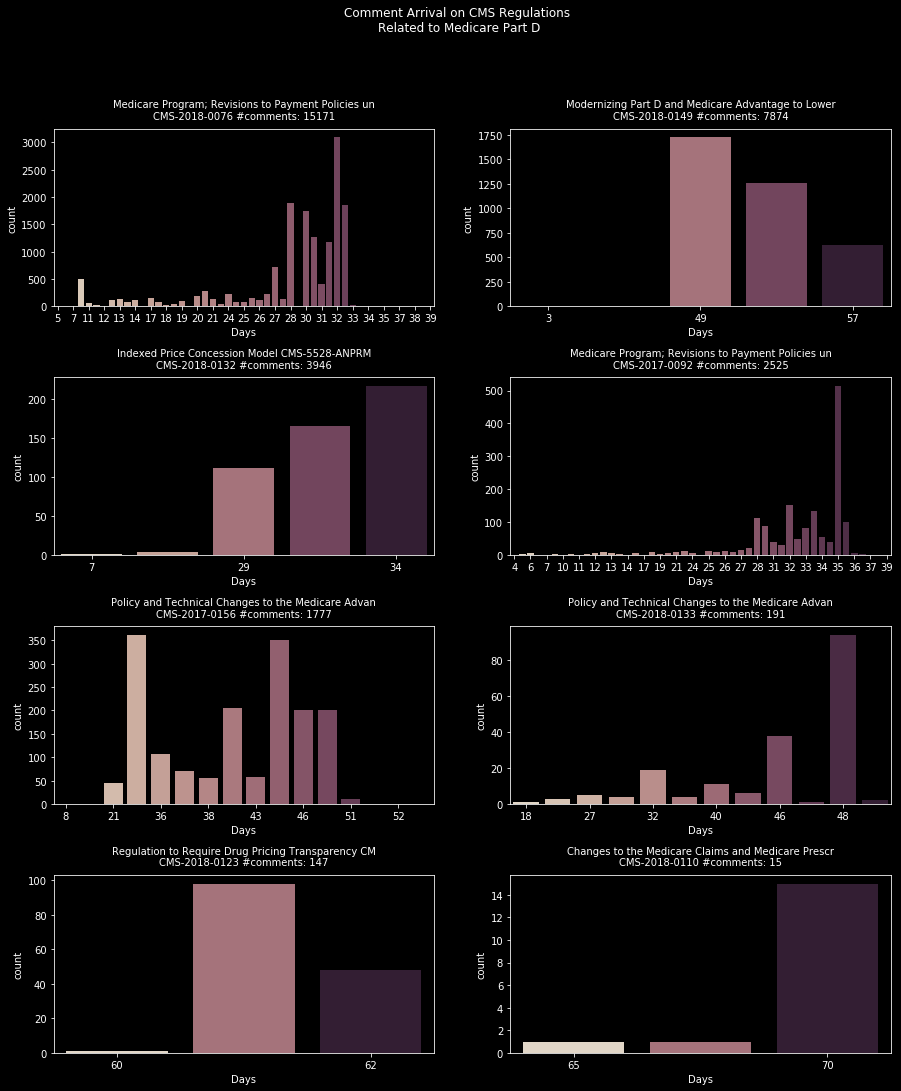

In [41]:
fig = plt.figure(figsize=(15, 17))
plt.style.use("dark_background")
plt.suptitle("Comment Arrival on CMS Regulations \nRelated to Medicare Part D")
plt.subplots_adjust(wspace=0.2, hspace=0.4)

for ind,key in enumerate(plot_order): 
#for ind,key in enumerate(dat2plot): 
    ax = fig.add_subplot(4,2,ind+1)
    #sns.catplot(x="Days", kind="count", palette="ch:.25",data = dat2plot[key])
    g = sns.countplot(x="Days",  palette="ch:.25",data = dat2plot[key])
    g.axes.xaxis.set_major_locator(ticker.MultipleLocator(2))
    #g.axes.xaxis.set_major_formatter(ticker.ScalarFormatter())
    n_com = CMS.loc[CMS.docketId==key.upper(),'numberOfCommentsReceived'].values[0]
    #plt.title('{}\n Number of comments:{}'.format(key.upper(),n_com))
    plot_title = CMS.loc[CMS.docketId==key.upper(),'docketTitle'].values[0]
    plt.title('{}\n{} #comments: {}'.format(plot_title[:50],key.upper(),n_com), y = 1.02,  fontsize= 10)


In [42]:
fig.savefig('CMS Regulation_zk_2.png')

In [410]:
docket_interest

6     cms-2018-0135
17    cms-2018-0090
24    cms-2018-0076
39    cms-2018-0015
40    cms-2017-0165
Name: docketId, dtype: object

In [424]:
CMS.loc[CMS.docketId=='CMS-2018-0015','numberOfCommentsReceived']

38     134
39    9120
Name: numberOfCommentsReceived, dtype: int64

In [413]:
dat2plot['cms-2018-0015'].Days.describe()

count    9207.000000
mean       61.280113
std        16.901366
min         0.000000
25%        56.000000
50%        63.000000
75%        75.000000
max        90.000000
Name: Days, dtype: float64

In [426]:
CMS.drop(index=38, inplace = True)

In [451]:
CMS.docketTitle.str.contains("Medicare|Medicaid",case=False, regex=True).value_counts()

False    30
True     26
Name: docketTitle, dtype: int64

### Comments by Select CMS NPRMs

In [2]:
zippora=pd.read_csv('CMS_Docket_zk.csv')
zippora_dock = zippora.loc[zippora['Related to prescription drugs']==1,'docketId'].drop_duplicates()

In [3]:
zippora_plt = zippora.loc[zippora['Related to prescription drugs']==1,
                          ['docketId','numberOfCommentsReceived','title']]

In [4]:
zippora_plt=zippora_plt.groupby(by='docketId').sum().reset_index()

zippora_2 = (zippora_plt.merge(zippora.loc[:,['docketId','title']],on='docketId', how = 'inner').
             drop_duplicates('docketId'))

zippora_2['title2']=zippora_2.title.str.slice(31,60)

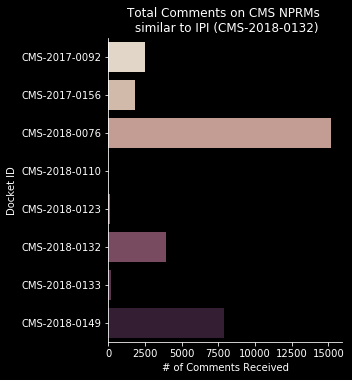

In [18]:
fig = plt.figure(figsize=(25, 17))
plt.style.use("dark_background")


g = sns.catplot(x='numberOfCommentsReceived', y='docketId', 
                palette="ch:.25",
                data = zippora_2, 
                kind = 'bar')

g.set_axis_labels("# of Comments Received", "Docket ID")
plt.title("Total Comments on CMS NPRMs \n similar to IPI (CMS-2018-0132)")

In [19]:
g.savefig('CMS Regulation_Plot_Overall_2.png')